### import

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as TV
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np

### 看是用cuda還是cpu

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
train_data = TV.datasets.MNIST("data/", train=True, transform=None,target_transform=None,download=True) #下載並匯入MNIST訓練資料
test_data = TV.datasets.MNIST("data/", train=False, transform=None,target_transform=None,download=True) #下載並匯入MNIST測試資料

print('Number of samples in train_data is: ',len(train_data))
print('Number of samples in test_data is: ',len(test_data)) 

100%|██████████| 9912422/9912422 [00:02<00:00, 3801716.75it/s] 


Extracting MNIST/MNIST\raw\train-images-idx3-ubyte.gz to MNIST/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 30337013.23it/s]


Extracting MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<?, ?it/s]


Extracting MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 3080117.83it/s]

Extracting MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST/MNIST\raw

Number of samples in train_data is:  60000
Number of samples in test_data is:  10000


### 看第一張圖片長什麼樣子

torch.Size([28, 28])


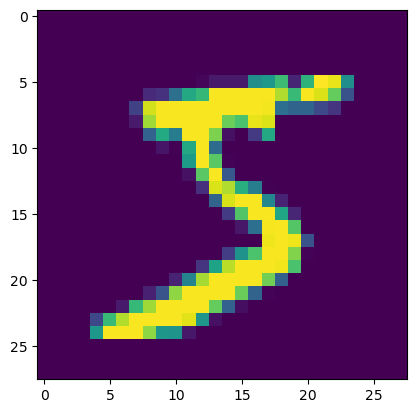

In [16]:
x = train_data.data[0] #讀取訓練集中的第一張圖片
plt.imshow(x) #把圖片顯示出來
print(x.size()) #顯示圖片大小

In [4]:
class CNN(nn.Module):
    def __init__(self):
        '''model layers'''
        super(CNN, self).__init__()
        # image shape: 1*28*28 (1: one color channel)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3,3))
        # output shape: 1*26*26 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3))
        # output shape: 1*24*24
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2))
        '''fully connected layers'''
        self.fc = nn.Linear(5408, 10) # 10 classes

    def forward(self, x):
        # model structure
        x = self.conv(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1) # log prob for numerical stability
        return output

In [5]:
def train(model, train_loader, optimizer, epochs, log_interval):
    model.train()
    for epoch in range(1, epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Clear gradient
            optimizer.zero_grad()

            # Forward propagation
            output = model(data)

            # Negative log likelihood loss (log prob + nll loss = prob + cross entropy loss)
            loss = F.nll_loss(output, target)

            # Back propagation
            loss.backward()

            # Parameter update
            optimizer.step()

            # Log training info
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))


In [6]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in test_loader:
            # Prediction
            output = model(data)

            # Compute loss & accuracy
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct

    test_loss /= len(test_loader.dataset)

    # Log testing info
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
def main():
    # Training settings
    BATCH_SIZE = 64
    EPOCHS = 2
    LOG_INTERVAL = 10

    # Define image transform
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # mean and std for the MNIST training set
    ])

    # Load dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True,
                       transform=transform)
    test_dataset = datasets.MNIST('./data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Create network & optimizer
    model = Net()
    optimizer = optim.Adam(model.parameters())

    # Train
    train(model, train_loader, optimizer, EPOCHS, LOG_INTERVAL)

    # Save and load model (for reference in case you are separating train and test files)
    torch.save(model.state_dict(), "mnist_cnn.pt")
    model = Net()
    model.load_state_dict(torch.load("mnist_cnn.pt"))

    # Test
    test(model, test_loader)


if __name__ == '__main__':
    main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.392644
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.163820
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.603842
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.431673
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.338834
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.299587
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.264885
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.396873
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.654762
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.285422
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.300526
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.214831
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.261118
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.156759
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.278894
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.342075
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.375385
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.281500
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.465081
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.370751
Train Epoch: 1 [12800/60000 (